# Ch.12 Stochastics

In [11]:
import math
import numpy as np  
import scipy.stats as scs
from pylab import plt, mpl
import warnings
warnings.filterwarnings('ignore')
print('Matplotlib version: {}'.format(mpl.__version__))
print('NumPy version: {}'.format(np.__version__))

Matplotlib version: 3.8.4
NumPy version: 1.26.4


## Random numbers
We may need (pseudo) random numbers to simulate random processes. NumPy provides methods to sample random numbers from several distributions: uniform, Gaussian or normal, Poisson, Chi square, and so forth. For example, we can sample 10 random numbers from the uniform distribution in the interval [0, 1) using the random() method of the generator instance. Several algorithms can be used to sample a distribution. The starting point is to sample from the uniform distribution for example using modula arithmetic. Once we have a sample of the uniform distribution we can create a sample from any other distribution.

In [2]:
np.random.seed(100)
rng = np.random.default_rng()
sample_size = 10
rng.random(sample_size)

array([0.36918629, 0.15323718, 0.60576303, 0.36196914, 0.70396887,
       0.08308443, 0.77535021, 0.20865927, 0.89922835, 0.00260795])

In [3]:
sample_size = 500
rn1 = rng.standard_normal(sample_size)  
rn2 = rng.normal(100, 20, sample_size)  
rn3 = rng.lognormal(mean=1.0, sigma=0.25, size=sample_size)  
rn4 = rng.poisson(lam=1.0, size=sample_size)  

Text(0.5, 1.0, 'Poisson')

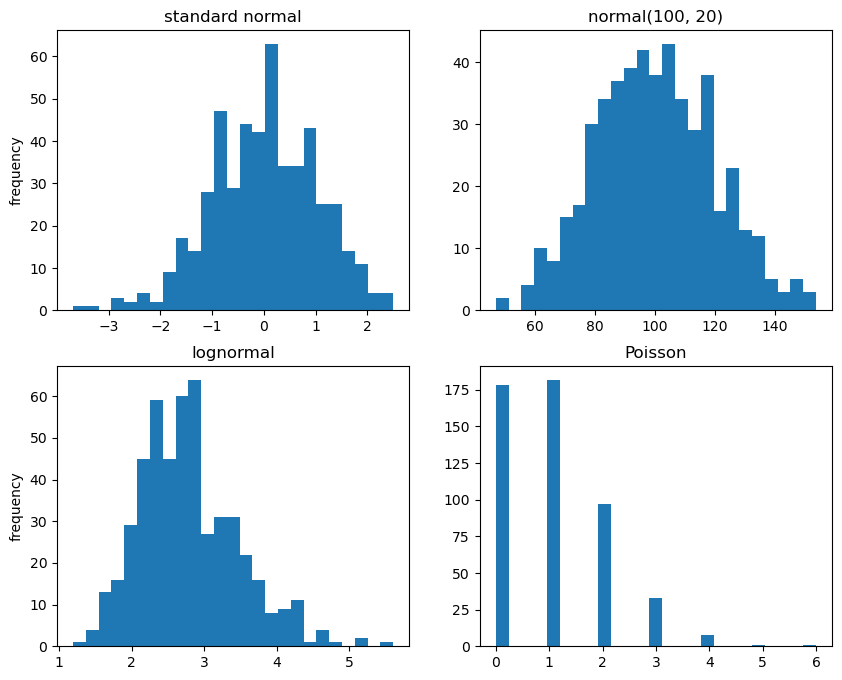

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
ax1.hist(rn1, bins=25)
ax1.set_title('standard normal')
ax1.set_ylabel('frequency')
ax2.hist(rn2, bins=25)
ax2.set_title('normal(100, 20)')
ax3.hist(rn3, bins=25)
ax3.set_title('lognormal')
ax3.set_ylabel('frequency')
ax4.hist(rn4, bins=25)
ax4.set_title('Poisson')

## Simulations
Simulations can be performed for valuation of derivatives and for risk management. We model the price of a derivative as a random process as a stochastic differential equation. In case it can be solved analytically we can use the solution to calculate the future price otherwise we can discretize the differential equation and compute the price from the start into the future. We can use a sample taken from a distribution to simulate a process. For example we can sample from a normal distribution to simulate the future index level according to the Black-Scholes-Merton (BSM) equation

$$S_T = S_0 \exp((r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T}z)$$

and we can build a distribution of the values returned from it. In the equation $S_0$ is the initial index level, r the riskless return rate, $\sigma$ the volatility, T the time horizon in years, and z a sample from the normal distribution. 

In [6]:
S0 = 100  
r = 0.05  
sigma = 0.25  
T = 2.0  
I = 10000  # number of samples to be returned from the normal dist.
z = rng.standard_normal(I)
ST1 = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * math.sqrt(T) * z) 
ST1.shape

(10000,)

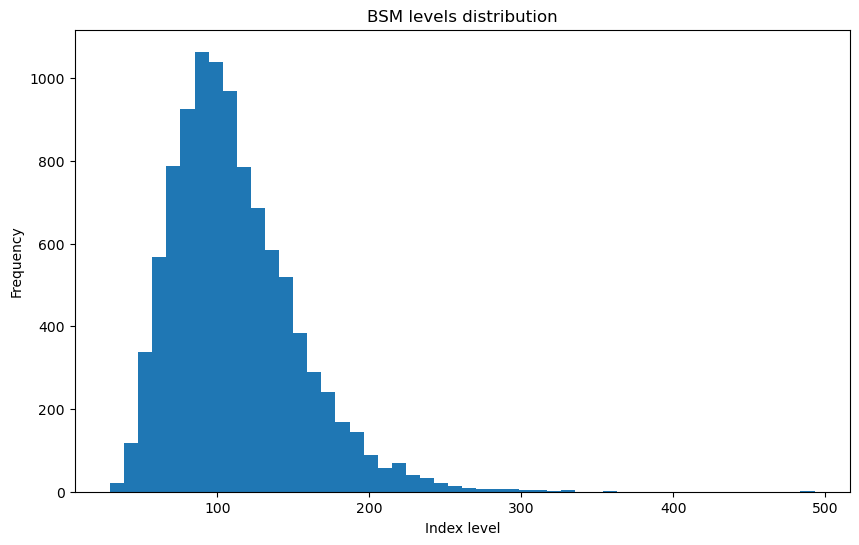

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(ST1, bins=50)
plt.title('BSM levels distribution')
plt.xlabel('Index level')
plt.ylabel('Frequency');

We can compare the distribution of the index levels from the BSM equation to a lognormal distribution with parameters with the same mean, $\mu = r$, and standard deviation $\sigma$.

In [8]:
ST2 = S0 * rng.lognormal((r - 0.5 * sigma ** 2) * T,
                        sigma * math.sqrt(T), size=I)  

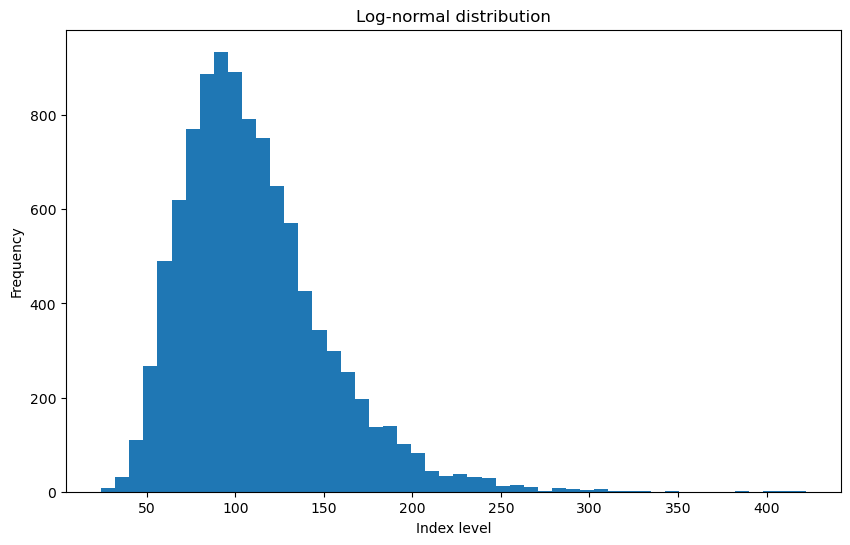

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(ST2, bins=50)
plt.title('Log-normal distribution')
plt.xlabel('Index level')
plt.ylabel('Frequency');

In [9]:
import scipy.stats as scs
def print_statistics(a1, a2):
    ''' Prints selected statistics.
    
    Parameters
    ==========
    a1, a2: ndarray objects
        results objects from simulation
    '''
    sta1 = scs.describe(a1)  
    sta2 = scs.describe(a2)  
    print('%14s %14s %14s' % 
        ('statistic', 'data set 1', 'data set 2'))
    print(45 * "-")
    print('%14s %14.3f %14.3f' % ('size', sta1[0], sta2[0]))
    print('%14s %14.3f %14.3f' % ('min', sta1[1][0], sta2[1][0]))
    print('%14s %14.3f %14.3f' % ('max', sta1[1][1], sta2[1][1]))
    print('%14s %14.3f %14.3f' % ('mean', sta1[2], sta2[2]))
    print('%14s %14.3f %14.3f' % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print('%14s %14.3f %14.3f' % ('skew', sta1[4], sta2[4]))
    print('%14s %14.3f %14.3f' % ('kurtosis', sta1[5], sta2[5]))

In [25]:
print_statistics(ST1, ST2)

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         25.211         28.219
           max        398.073        385.525
          mean        110.483        110.279
           std         40.427         39.782
          skew          1.151          1.072
      kurtosis          2.351          1.897


## Stochastic processes
A stochastic process can be represented as a sequence of random variables that can take a value from a probability distribution. We may assume that the stochastic variables are independent from each other or that there is a dependency, a correlation between one variable and one or more of the previous ones. If we assume a variable depends only on the previous one we are assuming that the process is a Markov process. A Markov process is said to be memoryless since it doesn't consider past values beyond the current one to predict the next one. 

### Geometric Brownian motion
Now we assume the price of an option to be a Markov process that follows the [Black-Scholes-Merton](https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model) stochastic differential equation, aka [geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion)

$$dS = rSdt + \sigma S dz$$

S is the index level, r the riskless return rate, $\sigma$ the volatility, t the time, and z the Brownian distribution. This equation when integrated analytically returns the BSM equation that we saw before

$$S_T = S_0 \exp((r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T}z)$$

The stochastic differential equation can also be discretized and integrated iteratively.

$$S_t = S_{t - \Delta t} \exp((r - \frac{1}{2}\sigma^2)\Delta t + \sigma \sqrt{\Delta t}z)$$

We take a number of M=50 consecutive samples of size I=10000 of the BSM process. Each time we add the random component sampled from the normal distribution. Every sample contains I stochastic values and at each time step a new value is calculated for each of them, following the BSM equation, based on the previous value and adding the brownian motion component. We store the samples as rows of an array S where the columns are the time steps. A row represents a time series, that is the evolution of one single random variable in M time steps. A column represents the I random variables at a particular time step. using only one time series would not be enough to statistically describe the stochastic process under observation. 

In [12]:
I = 10000 # sample size  
M = 50  
dt = T / M  
S = np.zeros((M + 1, I))  
S[0] = S0  
for t in range(1, M + 1):
    z = rng.standard_normal(I)
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt) * z)  
S.shape

(51, 10000)

We plot the histogram of the index levels at the latest time step. If we plot the distribution from the first sample we can see that the shape is Gaussian and then changes to an asymmetric shape after some time steps 

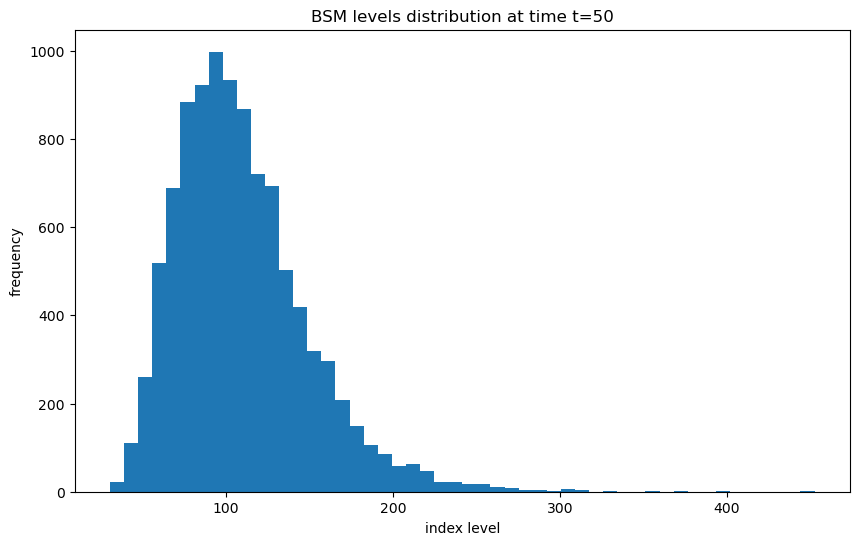

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=50)
plt.title('BSM levels distribution at time t=50')
plt.xlabel('index level')
plt.ylabel('frequency');

At each time step the distribution of the I values will be slightly different. The difference grows with time so that it will become more asymmetric. This can be seen directly from the plot of the I values with time, in M time steps. Each line is the path followed by one of the I random variables.

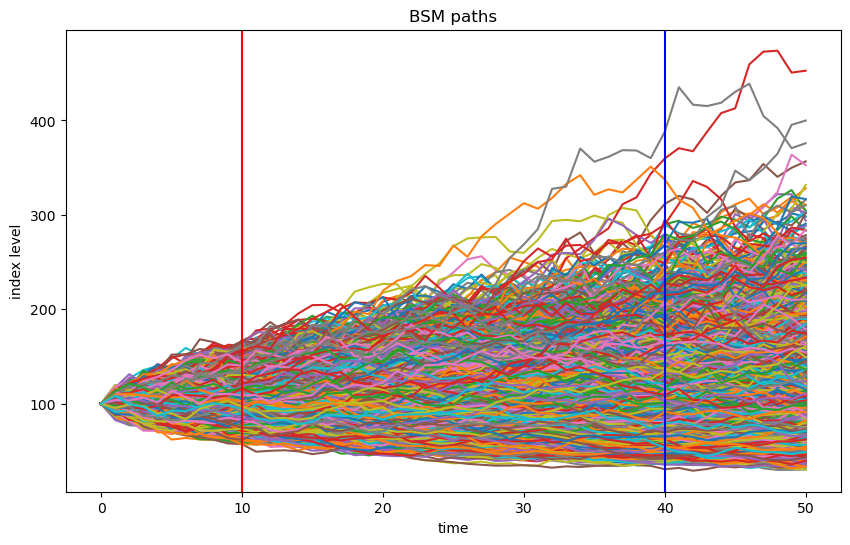

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(S[:, :], lw=1.5)
plt.axvline(x = 10, color = 'red', label = '10')
plt.axvline(x = 40, color = 'blue', label = '40')
plt.title('BSM paths')
plt.xlabel('time')
plt.ylabel('index level');

We compare the moments at two steps, one at t=10 and one at t=40. We can see that the mean value is not constant and the skewness, that is the asymmetry of the distribution, increases with time. 

In [21]:
print_statistics(S[10], S[40])

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         54.209         31.016
           max        186.590        296.374
          mean        102.183        108.033
           std         16.313         35.274
          skew          0.480          0.978
      kurtosis          0.465          1.508


### Square-root diffusion
We use another stochastic model of interest rates

$$dx_t = k(\theta - x_t)dt + \sigma \sqrt{x_t}dz_t$$

where $x_t$ is the interest rate level at time t, k is the mean-reversion factor, $\theta$ is the long-term mean of the process, $\sigma$ the constant volatility, and $z_t$ the brownian motion. The discretized version of the equation is

$$x_t = x_s + k(\theta - x_s^+)\Delta t + \sigma \sqrt{x_s^+ \Delta t}  z_t$$

As we have done for the geometric Brownian motion, we take a number of M=50 consecutive samples of size I=10000 of the square-root diffusion process. Each time we add the random component sampled from the normal distribution. Every sample contains I stochastic values and at each time step a new value is calculated for each of them, following the discretized equation, based on the previous value and adding the diffusion component.

In [23]:
x0 = 0.05  
kappa = 3.0  
theta = 0.02  
sigma = 0.1  
I = 10000
M = 50
dt = T / M

In [26]:
def srd_euler():
    xh = np.zeros((M + 1, I))
    x = np.zeros_like(xh)
    xh[0] = x0
    x[0] = x0
    for t in range(1, M + 1):
        xh[t] = (xh[t - 1] +
                 kappa * (theta - np.maximum(xh[t - 1], 0)) * dt +
                 sigma * np.sqrt(np.maximum(xh[t - 1], 0)) *
                 math.sqrt(dt) * np.random.standard_normal(I))  
    x = np.maximum(xh, 0)
    return x

In [28]:
x1 = srd_euler()
x1.shape

(51, 10000)

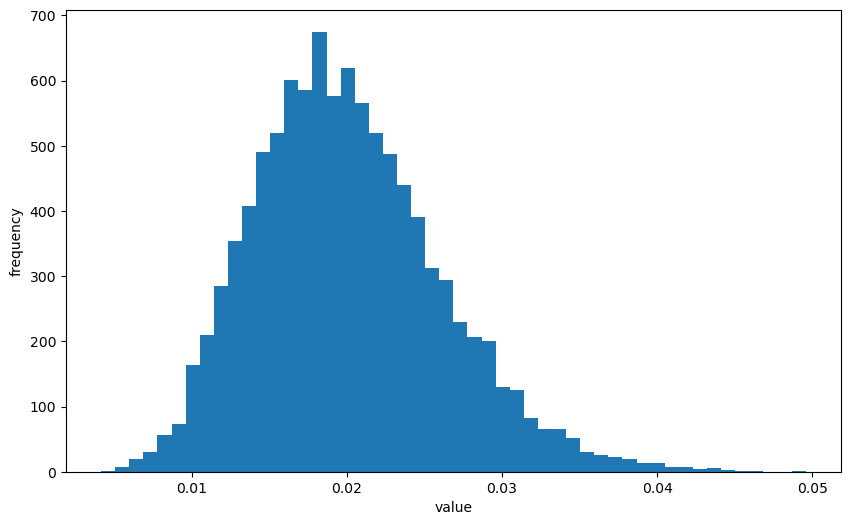

In [29]:
plt.figure(figsize=(10, 6))
plt.hist(x1[-1], bins=50)
plt.xlabel('value')
plt.ylabel('frequency');

We plot the paths followed by the I variables in the square-root diffusion process.

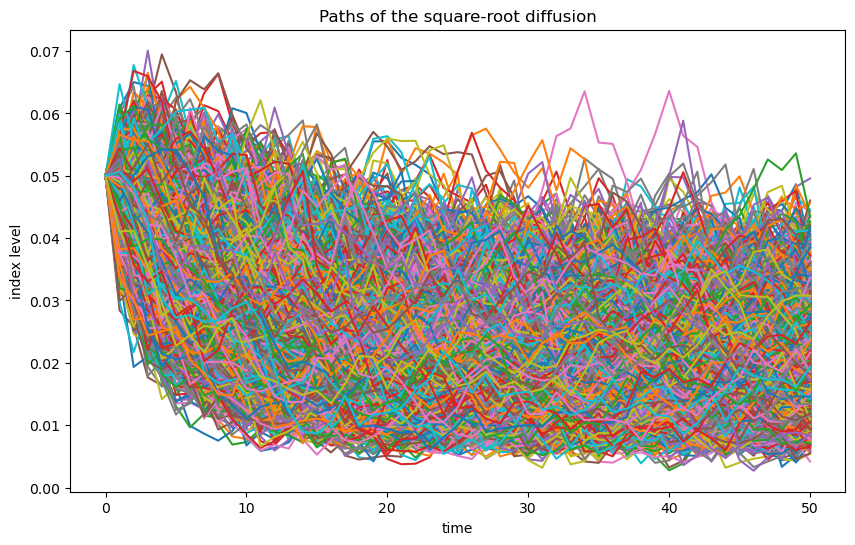

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(x1[:, :], lw=1.5)
plt.title('Paths of the square-root diffusion')
plt.xlabel('time')
plt.ylabel('index level');

### Stochastic volatility
We remove the constant volatility assumption from the BSM model and assume that the volatility is a random process as well as the price. The new model, called [Heston stochastic volatility model](https://www.jstor.org/stable/2962057), is represented by two stochastic differential equations and the correlation function $\rho$ of the Brownian motions $z^{(1)}$ and $z^{(2)}$, that is, between the price and the volatility.

$$dS_t = rS_tdt + \sqrt{v_t}S_t dz_t^{(1)}$$
$$dv_t = k_v(\theta_v - v_t)dt + \sigma_v \sqrt{v_t}dz_t^{(2)}$$
$$dz^{(1)}dz^{(2)} = \rho$$

In [35]:
S0 = 100.
r = 0.05
v0 = 0.1  
kappa = 3.0
theta = 0.25
sigma = 0.1
rho = 0.6  
T = 1.0

The Cholesky factorization splits the correlation matix C, an Hermitian positive-definite matrix, into a lower-triangular matrix $\hat{L}$ and its transpose $\hat{L}^T$
$$C = \hat{L} \hat{L}^T$$
The NumPy implementation returns the lower-triangular component.

In [36]:
corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat)  

In [37]:
cho_mat  

array([[1. , 0. ],
       [0.6, 0.8]])

In [38]:
M = 50
I = 10000
dt = T / M

In [40]:
ran_num = np.random.standard_normal((2, M + 1, I))
ran_num.shape

(2, 51, 10000)

In [41]:
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)

We compute the volatility using the 2nd equation and the  correlation matrix

In [42]:
v[0] = v0
vh[0] = v0

In [43]:
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])  
    vh[t] = (vh[t - 1] +
             kappa * (theta - np.maximum(vh[t - 1], 0)) * dt +
             sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * 
             math.sqrt(dt) * ran[1])  

In [44]:
v = np.maximum(vh, 0)

We can now compute the price level using the volatility value at each time step t

In [45]:
S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt +
                    np.sqrt(v[t]) * ran[0] * np.sqrt(dt))

We plot the volatility and the index level distributions for the last time step

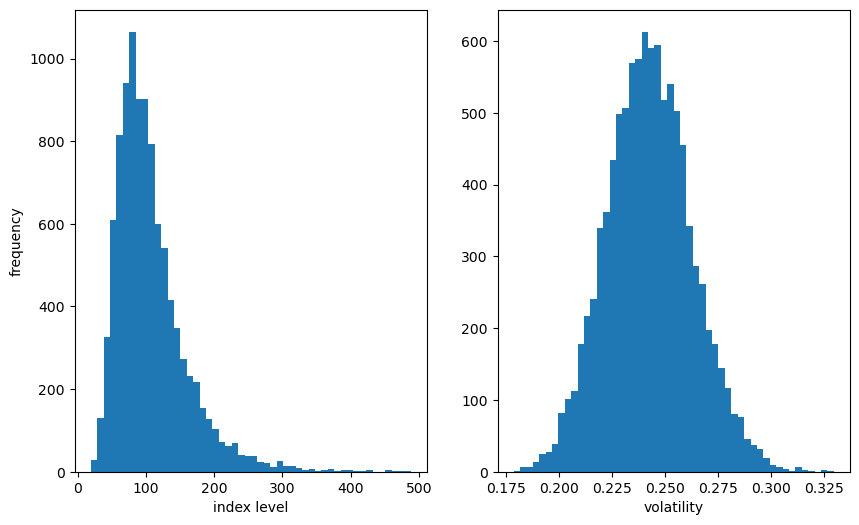

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(S[-1], bins=50)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility');

We can see from the volatility paths that it increases towards a mean value close to $\theta$

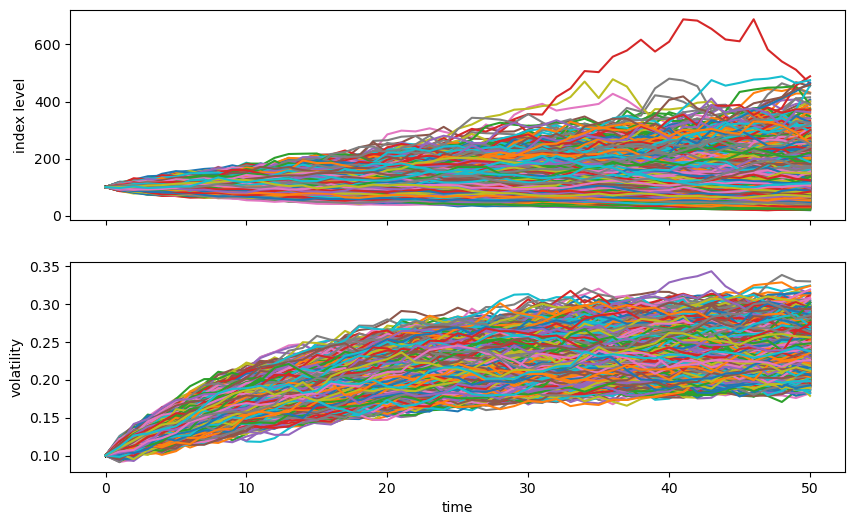

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 6))
ax1.plot(S[:, :], lw=1.5)
ax1.set_ylabel('index level')
ax2.plot(v[:, :], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility');

In [50]:
print_statistics(S[-1], v[-1])

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min         19.145          0.179
           max        488.391          0.330
          mean        107.081          0.243
           std         51.704          0.020
          skew          1.723          0.160
      kurtosis          5.056          0.059


### Jump diffusion
Stock prices show jumps, that is big and very rapid discontinuities, that cannot be represented by a diffusion process. Merton developed a new model based on BSM and adding a term to take into account these jumps

$$dS_t = (r - r_j)Sdt + \sigma S_t dz_t + J_tS_tdN_t$$

where $J_t$ is a jump at time t that follows a distribution, $r_j$ is a drift of the returns that takes into account the jumps, $N_t$ is a Poisson process. The other variables in the equation are the same as for the processes discussed before. The differential equation can be discretized using the Euler's method

$$S_t = S_{t - \Delta t} (e^{(r - r_j - \frac{\sigma^2}{2})\Delta t + \sigma \sqrt{\Delta t}z_t^1} + (e^{\mu_j + \delta z_t^2} - 1)y_t )$$

In [16]:
S0 = 100.
r = 0.05
sigma = 0.2
lamb = 0.75  
mu = -0.6  
delta = 0.25  
rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)  

In [17]:
T = 1.0
M = 50
I = 10000
dt = T / M

To simulate the Merton process we sample from two Gaussian distributions and one Poisson distribution

In [26]:
S = np.zeros((M + 1, I))
S[0] = S0
sn1 = np.random.standard_normal((M + 1, I))  
sn2 = np.random.standard_normal((M + 1, I))  
poi = np.random.poisson(lamb * dt, (M + 1, I))  
for t in range(1, M + 1, 1):
    S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt +
                       sigma * math.sqrt(dt) * sn1[t]) +
                       (np.exp(mu + delta * sn2[t]) - 1) *
                       poi[t])  
    S[t] = np.maximum(S[t], 0)

In [27]:
S.shape

(51, 10000)

From the plot of the I variables at time t=50 we can see that the distribution is bimodal. This is due to the jumps.

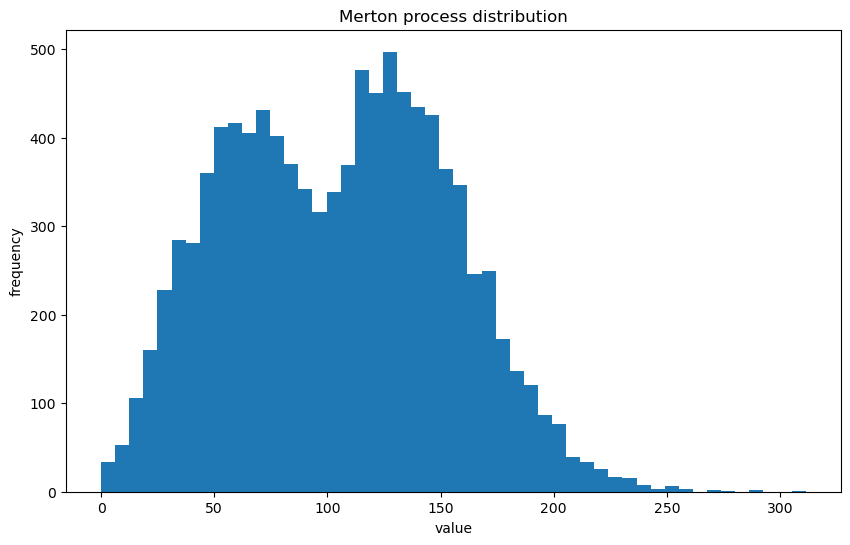

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(S[-1], bins=50)
plt.title('Merton process distribution')
plt.xlabel('value')
plt.ylabel('frequency');

We plot the first 10 time series to observe the jumps

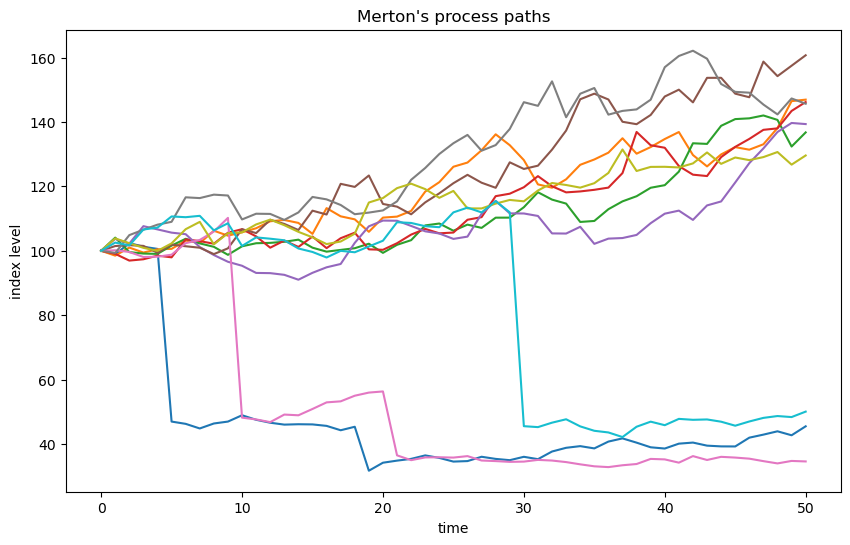

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(S[:, :10], lw=1.5)
plt.title('Merton\'s process paths')
plt.xlabel('time')
plt.ylabel('index level');

### Valuation
Options are financial derivatives linked to an underlying asset, for example stocks or bonds. In order to model a derivative price as a stochastic process linked to the underlying asset's price we have to calculate the value of the derivative. As stated on [Wikipedia](https://en.wikipedia.org/wiki/Option_(finance)): "an option is a contract which conveys to its owner, the holder, the right, but not the obligation, to buy or sell a specific quantity of an underlying asset or instrument at a specified strike price on or before a specified expiration date, depending on the style of the option."

### European options
The owner of a European style option can exercise the contract only at the specified expiration date. The payoff $h(S_T)$ of the option is the difference between the future price at the expiration date $S_T$ of the underlying asset and its strike price K.$ 

$$h(S_T) = max(S_T - K, 0)$$

The discounted price of the option, that is its present value, is given by the equation

$$C_0 = e^{-rT} \int_0^\infty{h(s)q(s)ds}$$

This equation can be discretized in order to compute the static value of the option using Monte Carlo integration

$$C_0 = e^{-rT} \frac{1}{I}\sum_{i=1}^I h(S_T)$$

In [30]:
S0 = 100.
r = 0.05
sigma = 0.25
T = 1.0
I = 50000

In [37]:
def gen_sn(M, I, anti_paths=True, mo_match=True):
    ''' Function to generate random numbers for simulation.
    
    Parameters
    ==========
    M: int
        number of time intervals for discretization
    I: int
        number of paths to be simulated
    anti_paths: boolean
        use of antithetic variates
    mo_math: boolean
        use of moment matching
    '''
    if anti_paths is True:
        sn = np.random.standard_normal((M + 1, int(I / 2)))
        sn = np.concatenate((sn, -sn), axis=1)
    else:
        sn = np.random.standard_normal((M + 1, I))
    if mo_match is True:
        sn = (sn - sn.mean()) / sn.std()
    return sn

In [38]:
def gbm_mcs_stat(K):
    ''' Valuation of European call option in Black-Scholes-Merton
    by Monte Carlo simulation (of index level at maturity)
    
    Parameters
    ==========
    K: float
        (positive) strike price of the option
    
    Returns
    =======
    C0: float
        estimated present value of European call option
    '''
    sn = gen_sn(1, I)
    # simulate index level at maturity
    ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T 
                 + sigma * math.sqrt(T) * sn[1])
    # calculate payoff at maturity
    hT = np.maximum(ST - K, 0)
    # calculate MCS estimator
    C0 = math.exp(-r * T) * np.mean(hT)
    return C0

In [41]:
print('Price of the European option: {:.2f}'.format(gbm_mcs_stat(K=105.)))

Price of the European option: 10.03


In [42]:
def gbm_mcs_dyna(K, option='call'):
    ''' Valuation of European options in Black-Scholes-Merton
    by Monte Carlo simulation (of index level paths)
    
    Parameters
    ==========
    K: float
        (positive) strike price of the option
    option : string
        type of the option to be valued ('call', 'put')
    
    Returns
    =======
    C0: float
        estimated present value of European call option
    '''
    dt = T / M
    # simulation of index level paths
    S = np.zeros((M + 1, I))
    S[0] = S0
    sn = gen_sn(M, I)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt 
                + sigma * math.sqrt(dt) * sn[t])
    # case-based calculation of payoff
    if option == 'call':
        hT = np.maximum(S[-1] - K, 0)
    else:
        hT = np.maximum(K - S[-1], 0)
    # calculation of MCS estimator
    C0 = math.exp(-r * T) * np.mean(hT)
    return C0

In [48]:
print('Estimated present value of the European call option (dynamic): {:.2f}'.format(gbm_mcs_dyna(K=105., option='call')))

Estimated present value of the European call option (dynamic): 10.14


In [50]:
print('Estimated present value of the European put option (dynamic): {:.2f}'.format(gbm_mcs_dyna(K=105., option='put')))

Estimated present value of the European put option (dynamic): 9.88


### American options
The owner of an American style option can exercise the contract at any date before the expiration date. This makes the calculation of the present value of the option more complex than for the European one. The main problem is to compute the optimal time to exercise the option. The type of problem is called *optimal stopping* or *early stopping*.

### Risk measures
The other application of the stochastic models is to estimate the risk of losses. In Finance two types of risks are considered: market risk and credit risk. 

### Value-at-Risk (VaR)
One measure of risk is the Value-at-Risk or VaR, that is the loss that will not be exceeded, with some confidence level, e.g. 95%, over a given period of time. In case the loss is higher then that the VaR does not provide information. As an example, we want to assess the risk of a derivative to loose its value. We calculate the value $S_T$ of a European option at time t=T using the closed form solution of the BSM model

$$S_T = S_0 \exp((r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T}z)$$

In [18]:
S0 = 100
r = 0.05
sigma = 0.25
T = 30 / 365. # number of days
I = 10000 # number of random variables

In [17]:
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.standard_normal(I)) 

We sort the I profits (or losses) in descending order 

In [22]:
R_gbm = np.sort(ST - S0)
print('Max loss: {:.2f}'.format(R_gbm[0]))

Max loss: -22.80


We plot the distribution of the profits/losses

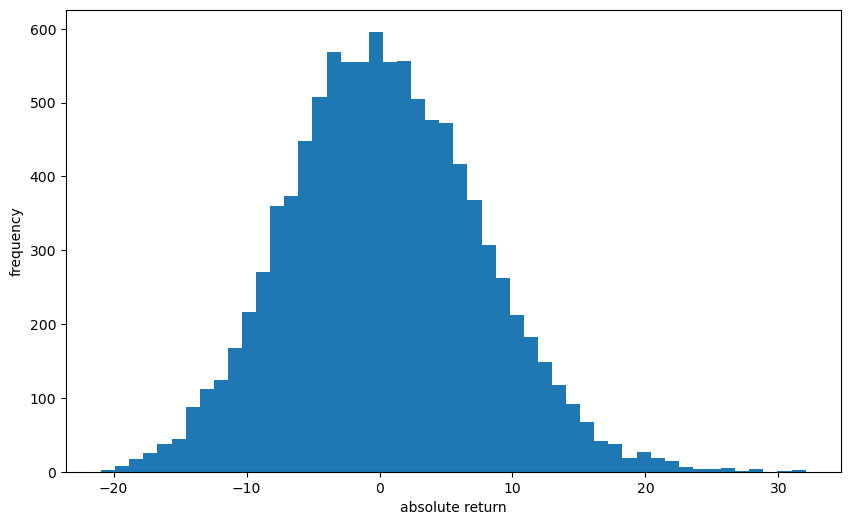

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(R_gbm, bins=50)
plt.xlabel('absolute return')
plt.ylabel('frequency');

We compute the percentiles from 1% to 10%. The percentiles represent the confidence levels. 

In [12]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]
var = scs.scoreatpercentile(R_gbm, percs)
print('%16s %16s' % ('Confidence Level', 'Value-at-Risk'))
print(33 * '-')
for pair in zip(percs, var):
    print('%16.2f %16.3f' % (100 - pair[0], -pair[1]))

Confidence Level    Value-at-Risk
---------------------------------
           99.99           20.429
           99.90           18.801
           99.00           15.151
           97.50           13.211
           95.00           11.111
           90.00            8.645


### Credit Value-at-Risk (CVaR)
For the credit risk we have to figure out the probability of default in addition to the loss level.As an example we start with the BSM equation

In [40]:
S0 = 100.
r = 0.05
sigma = 0.2
T = 1. # one year
I = 100000

In [25]:
ST = S0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.standard_normal(I))

We set the average fixed loss L and the probability of default p

In [34]:
L = 0.5 
p = 0.01

We compute the probability of loss events using the Poisson distribution

In [37]:
D = np.random.poisson(p * T, I)

We need only one default event

In [38]:
D = np.where(D > 1, 1, D) 

In case of no default the risk-neutral value of the asset would be the discounted present value of the future index level

In [39]:
math.exp(-r * T) * np.mean(ST)

100.03512225559695

We calculate the discounted loss in case of default 

In [30]:
CVaR = math.exp(-r * T) * np.mean(L * D * ST)  
CVaR

0.48724136092853987

Finally we calculate the present value adjusted by the simulated CVaR

In [31]:
S0_adj = S0 - CVaR  
S0_adj

99.51275863907146

We count the number of loss events due to credit risk

In [32]:
np.count_nonzero(L * D * ST)

986

Finally we plot the distribution of loss events by amount

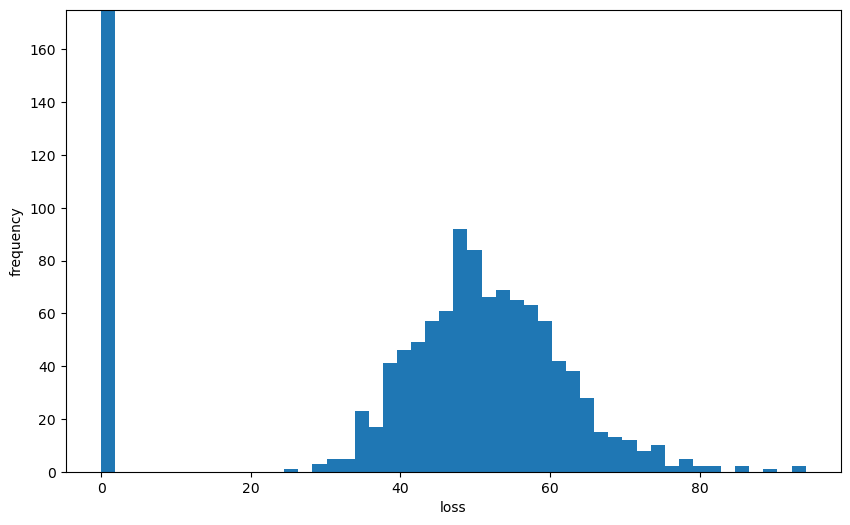

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(L * D * ST, bins=50)
plt.xlabel('loss')
plt.ylabel('frequency')
plt.ylim(ymax=175);